# Transfer Learning

The learning goals of this tutorial are:

- Illustrate the transfer learning procedure using a model pre-trained on [ImageNet](http://www.image-net.org/).
- Get familiar with the Keras API to load pre-trained models and freeze layers during training.


1. Set up your data augmentation

2. Define your callbacks (save your model, patience, etc.)

3. Transfer Learning
    
    3.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)
    
    3.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model
    
    3.3. Add a top (i.e., the prediction layers)
    
    3.4  Train the model using your dataset
    
    3.5 Unfreeze the layers and fine-tune the whole model (i.e., train your model with a very small learning rate)
    
    3.6 If you are satisfied with the train and validation performance go to the next step
    
    3.7 If you are not satisfied with the train and validation performance go back to step 6.1.

4. Test your model on the test set and extract relevant metrics

In [3]:
import tensorflow as tf
import numpy as np
import glob
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pylab as plt
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Set up your data augmentation

In [62]:
bs = 64 # batch size


X = np.load("Q:/HN_TL/sagittal_set_150.npy")
X  = 255*(X - X.min(axis = (1,2),keepdims = True))/(X.max(axis = (1,2),keepdims = True)- X.min(axis = (1,2),keepdims = True))
#X = np.load('C:/Users/owenpaetkau/Documents/PythonScripts/Transfer_Learning/sagittal_set_150.npy')
Y = np.load("Q:/HN_TL/mdadi_bin_labels.npy")
#Y = np.load('C:/Users/owenpaetkau/Documents/PythonScripts/Transfer_Learning/mdadi_labels.npy')

"""from tensorflow.keras.utils import to_categorical

class_names = ['mild','moderate','severe']
Y_new = []
for i in Y:
    for k,j in enumerate(class_names):
        if i == j:
            Y_new.append(k)

print(Y_new)

Y = np.array(Y_new)"""

print(type(Y))
print(Y)

indexes = np.arange(X.shape[0],dtype = int)
np.random.shuffle(indexes)
X = X[indexes]
Y = Y[indexes]
train = int(0.8*indexes.size)
val = int(0.90*indexes.size)

Xtrain = X[:train]
Ytrain = Y[:train] 

Xval = X[train:val]
Yval = Y[train:val]

Xtest = X[val:]
Ytest = Y[val:] 

print(Ytest)
print(Yval)

print(Xtrain.shape,Xval.shape,Xtest.shape)

<class 'numpy.ndarray'>
[0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1
 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0]
[0 1 1 0 1 1 0 1 1 0 1 1 1 0]
[1 1 0 1 1 1 1 0 1 0 0 1 1]
(106, 300, 300, 3) (13, 300, 300, 3) (14, 300, 300, 3)


## 2. Define your callbacks (save your model, patience, etc.)

In [63]:
model_name_it = "ct_classifier_en_b0_it.h5"
model_name_ft = "ct_classifier_en_b0_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 3. Transfer Learning

3.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

3.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model

3.3. Add a top (i.e., the prediction layers)

In [64]:
img_height = 300
img_width = 300

# Defining the model
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(2,activation = 'softmax')(x2) 
model = tf.keras.Model(inputs = base_model.input, outputs =out)

print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 10, 10, 1280)      4049571   
_________________________________________________________________
flatten_7 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 256002    
Total params: 4,305,573
Trainable params: 256,002
Non-trainable params: 4,049,571
_________________________________________________________________
None


## 3.4 Train the model using your dataset

In [65]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit(Xtrain,Ytrain, epochs= 5 , verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (Xval,Yval))

Epoch 1/5
4/4 [==============================] - 4s 339ms/step - loss: 1.3036 - accuracy: 0.5094 - val_loss: 1.0775 - val_accuracy: 0.6154
Epoch 2/5
4/4 [==============================] - 0s 88ms/step - loss: 0.9836 - accuracy: 0.6415 - val_loss: 2.2837 - val_accuracy: 0.3077
Epoch 3/5
4/4 [==============================] - 0s 88ms/step - loss: 0.7382 - accuracy: 0.6321 - val_loss: 0.9680 - val_accuracy: 0.5385
Epoch 4/5
4/4 [==============================] - 0s 89ms/step - loss: 0.5762 - accuracy: 0.7264 - val_loss: 0.9937 - val_accuracy: 0.6154
Epoch 5/5
4/4 [==============================] - 0s 89ms/step - loss: 0.2120 - accuracy: 0.8774 - val_loss: 1.6709 - val_accuracy: 0.3846


In [67]:
# Fine-tuning the model
model = tf.keras.models.load_model(model_name_it)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-7),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(Xtrain,Ytrain, epochs= 10 , verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = (Xval,Yval))


Fine-tuning model
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 10, 10, 1280)      4049571   
_________________________________________________________________
flatten_7 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 256002    
Total params: 4,305,573
Trainable params: 4,263,550
Non-trainable params: 42,023
_________________________________________________________________
None
Epoch 1/10
4/4 [==============================] - 7s 630ms/step - loss: 0.5456 - accuracy: 0.7170 - val_loss: 0.7469 - val_accuracy: 0.7692
Epoch 2/10
4/4 [==============================] - 2s 395ms/step - loss: 0.5386 

## 4. Test your model on the test set and extract relevant metrics

In [68]:
# Testing the model in the initial training
model = tf.keras.models.load_model(model_name_it)
model.evaluate(Xtest,Ytest)

# Testing the model in the fine tuning
model = tf.keras.models.load_model(model_name_ft)
model.evaluate(Xtest,Ytest)
print(Ytest)

1/1 [==============================] - 1s 782ms/step - loss: 0.7975 - accuracy: 0.5714
[0 1 1 0 1 1 0 1 1 0 1 1 1 0]


[1 1 1 0 0 1 1 1 1 1 1 0 1 1]
[0 1 1 0 1 1 0 1 1 0 1 1 1 0]


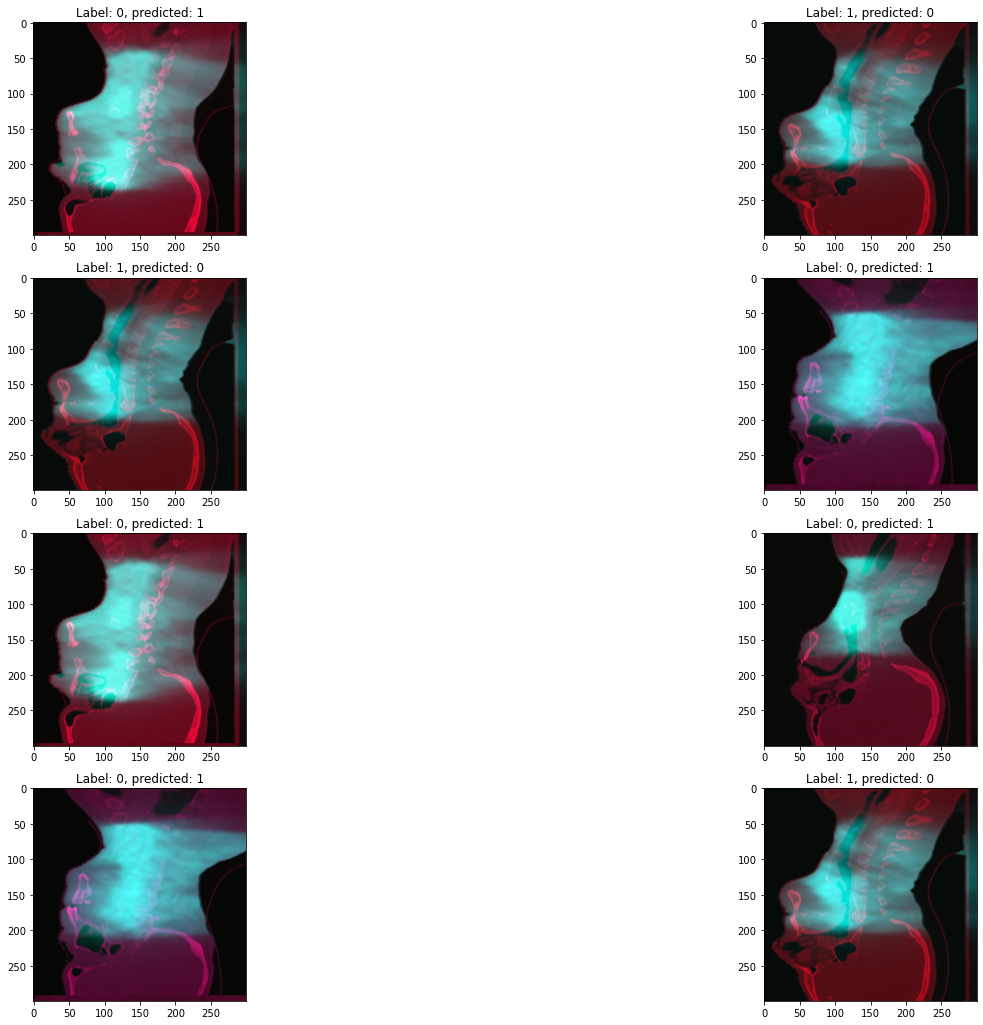

In [71]:
Ypred = model.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

print(Ypred)
print(Ytest)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = True)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Ytest[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()